# Prepare the data

In [50]:
# hide jupyter warning
import warnings
warnings.filterwarnings('ignore')

In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [52]:
import pyLDAvis
import pyLDAvis.gensim

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

In [53]:
df = pd.read_json('../input/iphone-12-tweets-fr.json', lines=True)
#df.head()

In [54]:
# remove duplicates 
# 840 tweets had been droped

df = df[df['lang'] == 'fr']
df = df.sort_values("content") 
  
# dropping ALL duplicte values 
df = df.drop_duplicates(subset ="content", keep = 'first')

In [55]:
# selectionner que les tweets qui répondent au requetes de l'utilisateur

data = df['content']

keywords = ['stockage', 'écran', 'ecran', 'autonomie', 'réseau',
            'reseau', 'alimentation',
           'appareil', 'appareil photo', 'processeur', 'multimédia', 
            'multimedia', 'résolution', 'resolution',
           'batterie', 'os', 'pièces', 'pieces' , 'couleur',
           'communication', 'sans fil', 'synchronisation', 'coloris', 
            'poids', 'système', 'systeme',
           'dimensions', 'prix', 'service', 'client', 'support', 'payement']

data = data[data.str.contains('|'.join(keywords), case=False)]

# supprimer les tweets inutiles (publicité, concours ..)

ads_words = [
    '#concours', '#jeuconcours', '#giveaway',
    '#gagne' ,'#gangner', '#promo', '#promotion', '#publicité',
    '#contest', '#ad', '#pub', '#réduction', '#vote', 'votez', 'vote']

data = data[~data.str.contains('|'.join(ads_words), case=False)]

In [56]:
import re
import json
from html.parser import HTMLParser
from io import StringIO

import demoji
demoji.download_codes()

... OK (Got response in 0.37 seconds)
Writing emoji data to /home/azureuser/.demoji/codes.json ...
... OK


In [57]:
class MLStripper(HTMLParser):
        def __init__(self):
            super().__init__()
            self.reset()
            self.strict = False
            self.convert_charrefs= True
            self.text = StringIO()
        def handle_data(self, d):
            self.text.write(d)
        def get_data(self):
            return self.text.getvalue()
        
def html_free_text(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

def emoji_free_text(text):
    return demoji.replace(text, '').strip()

def url_free_text(text):
    text = re.sub(r'(?:\@|https?\://)\S+', '', text)
    return text
    
with open('../input/abrivot_fr.json', encoding='utf-8') as f:
        abrivot = json.load(f)    
def free_abrivot_text(text):
    words = text.lower().split()
    text_out = [abrivot[word] if word in abrivot else word for word in words]
    return ' '.join(text_out)

In [58]:
%%time

data_free_html = data.apply(html_free_text)
data_free_emoji = data_free_html.apply(emoji_free_text)
data_free_url = data_free_emoji.apply(url_free_text)
data_free_abrivot = data_free_url.apply(free_abrivot_text)

CPU times: user 8.87 s, sys: 0 ns, total: 8.87 s
Wall time: 8.87 s


In [59]:
data_free_abrivot.head()

19381    " actualité : le format apple proraw disponibl...
6029     " apple est une marque de snobinards " vient d...
11631    "android ferait l'affaire" bande de chiens de ...
2833     "anker lance sa propre batterie externe magsaf...
32661    "apple : certains iphone 12 mini souffrent d'u...
Name: content, dtype: object

In [61]:
# Build the bigram and trigrams

data = list(data_free_abrivot)

bigram = gensim.models.Phrases(data, min_count=20, threshold=100)
trigram = gensim.models.Phrases(bigram[data], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [75]:
# define a preprocessing function

# only need tagger, no need for parser and named entity recognizer, for faster implementation
nlp = spacy.load('fr_core_news_sm', disable=['parser', 'ner'])

# get stopwords
with open('../input/fr_stopwords.txt', encoding='utf-8') as f:
    fr_stopwords = f.read().splitlines()
stop_words = nlp.Defaults.stop_words.union(fr_stopwords)


# final preprocesser
def process_words(texts, stop_words=stop_words, allowed_tags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    
    """Convert a document into a list of lowercase tokens, build bigrams-trigrams, implement lemmatization"""
    
    # remove stopwords, short tokens and letter accents 
    texts = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3, max_len=20) if word not in stop_words] for doc in texts]
    
    # bi-gram and tri-gram implementation
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    texts_out = []
    
    # implement lemmatization and filter out unwanted part of speech tags
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_tags])
    
    # remove stopwords and short tokens again after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts_out]    
    
    return texts_out

In [76]:
%%time

data_ready = process_words(data)

CPU times: user 45.8 s, sys: 0 ns, total: 45.8 s
Wall time: 45.8 s


In [77]:
# create the Dictionary

id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 10254


In [78]:
# create the corpus
corpus = [id2word.doc2bow(text) for text in data_ready]

In [80]:
dict_corpus = {}

for i in range(len(corpus)):
    for idx, freq in corpus[i]:
        if id2word[idx] in dict_corpus:
            dict_corpus[id2word[idx]] += freq
        else:
            dict_corpus[id2word[idx]] = freq

dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

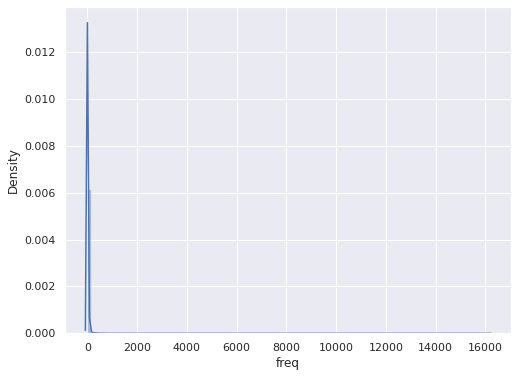

In [81]:
plt.figure(figsize=(8,6))
sns.distplot(dict_df['freq'], bins=100);

In [83]:
dict_df.sort_values('freq', ascending=False).head(10)

,freq
iphon,16148
pro,5390
max,2509
iphone,2458
prix,1940
mini,1681
batterie,1394
photo,1319
ecran,1306
apple,989


In [84]:
threshold = 1500
extension = dict_df[dict_df.freq>threshold].index.tolist()

In [86]:
# add high frequency words to stop words list
stop_words.update(extension)
# rerun the process_words function
data_ready = process_words(data)
# recreate Dictionary
id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 10210


In [87]:
# Filter extreme words
# Filter out words that occur less than 10 documents, or more than
# 50% of the documents.

id2word.filter_extremes(no_below=10, no_above=0.5)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 1387


In [88]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Topic Modeling